In [1]:
#using DifferentialEquations
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using JLD2
using Base.Threads
using Distributions
#Pkg; Pkg.add("DistributedArrays")
println("nthreads = $(nthreads())")
using Printf
#import Pkg; Pkg.add("IJuliaBell")
using IJuliaBell
#import Pkg; Pkg.add("ArraysOfArrays")
using ArraysOfArrays
#import Pkg; Pkg.add("SummationByPartsOperators")
using SummationByPartsOperators
using LinearAlgebra

nthreads = 10


## 2D PIC Escheleton 

Here we run the 2D version of PIC. 

In [2]:
include("aux_functions/aux_functions.jl")
include("aux_functions/inidat_aux_functions.jl")


f_x

### Initial Distribution

## Initial data configurations (Particles first)

In [3]:
## initial data configurations

trys = false
thermal = false
weibel = false
weibel_norel = false
damped = false
#trys = true
#thermal = true
#weibel = true
two_particle_distribution = false
weibel_norel = true
#damped = true




true

In [4]:
const order = 5
const D = 2


# Particle numbers
const N_exp = 7 #5 #6 #7 #6 #7 #7#6#5 #6
N = 10^(N_exp)

if  thermal
    #run_name = "thermal_norel_"
    run_name = "thermal_rel_"
    #data_name = "par_dis_norel_thermal_"
    data_name = "par_dis_rel_thermal_"
    J = (50,50)
    Box_x = (0.0,1.0,0.0,1.0) 
    nm = [1,1]
    Box_array = [i for i in Box_x]
    k = 2π*nm./(Box_array[2:2:end]-Box_array[1:2:end-1]) # this here is k, not \hat{k}
    alpha_exp = 1 # 2 3 8
    α = 10.0^(-alpha_exp) # 0.1 0.001
    par_f_x = (α, nm, Box_x)
    exp_Theta = 3
    θ = 10.0^(-exp_Theta)
    p_max = sqrt((1+10*θ)^2-1)
    Box_p = (-p_max,p_max,-p_max,p_max)
    par_f_p = (θ,D)
    #par_f_p_1 = (θ,1,D) #to compute the norm of f_p
    #norm = int_mid_point_f(f_p_rel, par_f_p_1, [20_000,20_000], Box_p)
    #par_f_p_rel = (θ,norm,D)
    par_init = (α, nm)
    data_name = data_name * "nm_[$(nm[1]),$(nm[2])]_"
    data_name = data_name * "alp$(alpha_exp)_N$(N_exp)_Th$(exp_Theta)"
    run_name = run_name * "Box_$(Box_x[2]-Box_x[1])x$(Box_x[4]-Box_x[3])_J_$(J[1])x$(J[2])_nm_[$(nm[1]),$(nm[2])]__Th$(exp_Theta)_alp$(alpha_exp)"
elseif weibel_norel
    run_name = "weibel_norel_"
    data_name = "par_dis_norel_weibel_"
    J = (100,100)
    Box_x = (0.0,15.0,0.0,15.0) 
    Ax = 24 # velocity anisotropy in the x direction
    alpha_exp = 8 # 8 so that is extremely small i.e. zero
    α = 10.0^(-alpha_exp) # 0.1 0.001
    par_f_x = (α, [0.0,0.0], Box_x)
    exp_Theta = 3
    θ = 10.0^(-exp_Theta)
    p_max = sqrt((1+10*θ)^2-1)
    Box_p = (-sqrt(Ax)*p_max, sqrt(Ax)*p_max,- p_max, p_max)
    par_f_p = (θ,D,Ax)
    par_init = (α, Ax)
    data_name = data_name * "Ax_$(Ax)_"
    data_name = data_name * "alp$(alpha_exp)_N$(N_exp)_Th$(exp_Theta)"
    run_name = run_name * "Box_$(Box_x[2]-Box_x[1])x$(Box_x[4]-Box_x[3])_J_$(J[1])x$(J[2])_Ax_$(Ax)_Th$(exp_Theta)_alp$(alpha_exp)"
elseif two_particle_distribution
    run_name = "two_particle_"
    data_name = "par_dis_rel_two_partible_MN_"
    J = (64,64)::NTuple{2,Int64} #no parece funcionar el dar el tipo NTuple, al menos no así.
    Box_x = (0.0,15.0,0.0,15.0) 
    Ax = 25 # velocity anisotropy in the x direction
    alpha_exp = 8 # 8 so that is extremely small i.e. zero
    α = 10.0^(-alpha_exp) # 0.1 0.001
    par_f_x = (α, [0.0,0.0], Box_x)
    exp_Theta = 3
    θ1 = 10.0^(-exp_Theta)
    θ2 = Ax * θ1
    p_max = 10*θ2
    Box_p = (-p_max,p_max,-p_max,p_max)
    par_init = (α, Ax)
    @show pars_f = (θ1,θ2,Ax)
    data_name = data_name * "Ax_$(Ax)_"
    data_name = data_name * "alp$(alpha_exp)_N$(N_exp)_Th$(exp_Theta)"
    run_name = run_name * "Box_$(Box_x[2]-Box_x[1])x$(Box_x[4]-Box_x[3])_J_$(J[1])x$(J[2])_Ax_$(Ax)_Th$(exp_Theta)_alp$(alpha_exp)"
elseif damped
    run_name = "damped_I2_"
    data_name = "par_dis_rel_damped_"
    J = (930,100)::NTuple{2,Int64}
    Box_x = (0.0,7.455,0.0,1.0) # corner box coordinates
    Box_array = [i for i in Box_x]
    nm = [15,0] # wave numbers
    k = 2π*nm./(Box_array[2:2:end]-Box_array[1:2:end-1]) # this here is k, not \hat{k}
    alpha_exp = 2 # 3 8
    α = 10.0^(-alpha_exp) # 0.1, 0.01 0.001
    par_f_x = (α, nm, Box_x)
    exp_Theta = 3
    θ = 10.0^(-exp_Theta)
    p_max = sqrt((1+10*θ)^2-1) #maximum of the momentum box
    Box_p = (-p_max,p_max,-p_max,p_max)
    par_f_p = (θ,D)
    #par_f_p_1 = (θ,1,D) #to compute the norm of f_p
    #norm = int_mid_point_f(f_p_rel, par_f_p_1, [20_000,20_000], Box_p)
    #par_f_p_rel = (θ,norm,D)
    data_name = data_name * "nm_[$(nm[1]),$(nm[2])]_"
    data_name = data_name * "alp$(alpha_exp)_N$(N_exp)_Th$(exp_Theta)"
    run_name = run_name * "Box_$(Box_x[2]-Box_x[1])x$(Box_x[4]-Box_x[3])_J_$(J[1])x$(J[2])_Th$(exp_Theta)_alp$(alpha_exp)"
end



@show data_name 

# EVOLUTION PARAMETERS

exp_t = 0 #0# 1 #2
t = 0.0
t_i = 0.0
t_f = 4.0*10.0^(exp_t)
M = 201 #10001 #1001 #11 #16001# 4001 # 81 # 2001 # time steps 
M_g = 201 #8001 #400 + 1 #number of outputs, starting from the initial data
dx = differentials(Box_x,J)
@show dx_min = minimum(dx)
@show dt = (t_f-t_i)/(M-1)
@show CFL = dt/dx_min


# for plotting and other things
x_p = [dx[1]*(i-1) for i in 1:J[1]] ;
y_p = [dx[2]*(i-1) for i in 1:J[2]] ;

Dx = periodic_derivative_operator(derivative_order=1, accuracy_order=6, xmin=Box_x[1], xmax=Box_x[2], N=J[1])
Dy = periodic_derivative_operator(derivative_order=1, accuracy_order=6, xmin=Box_x[3], xmax=Box_x[4], N=J[2])
Δx = dissipation_operator(Dx;
                     #mode=D.coefficients.mode
                     #,mode=ThreadedMode()
                     )
Δy = dissipation_operator(Dy;
                     #mode=D.coefficients.mode
                     #,mode=ThreadedMode()
                     )
const σx = 0.0 #1.0 #dissipation strength
const σy = 0.0 #1.0 #dissipation strength
dissipation = false
maxwell = true 

@show par_evolv = (t_i, t_f, M, M_g, dt)
@show par_grid = (N, J, Box_x, order)
#@show pars_f = (θ1,θ2,)



println("t_f = $(t_f), M = $M, dt = $(dt), exp_Theta = $(exp_Theta)")



run_name = run_name * "tf_$(convert(Int,10*t_f))_N$(N_exp)_M$(M)_o$(order)"
println(run_name)
println(data_name)


data_name = "par_dis_norel_weibel_Ax_24_alp8_N7_Th3"
dx_min = minimum(dx) = 0.15
dt = (t_f - t_i) / (M - 1) = 0.02
CFL = dt / dx_min = 0.13333333333333333


par_evolv = (t_i, t_f, M, M_g, dt) = (0.0, 4.0, 201, 201, 0.02)
par_grid = (N, J, Box_x, order) = (10000000, (100, 100), (0.0, 15.0, 0.0, 15.0), 5)
t_f = 4.0, M = 201, dt = 0.02, exp_Theta = 3
weibel_norel_Box_15.0x15.0_J_100x100_Ax_24_Th3_alp8tf_40_N7_M201_o5
par_dis_norel_weibel_Ax_24_alp8_N7_Th3


In [5]:
par_dis, data_name, pars, par_f_x, Box_x, par_f_p, Box_p = retrieve_initial_data_D("Initial_Distributions/" * data_name * ".jld2")
#@show data_name_from_inidat, pars, par_f_x, Box_x, par_f_p, Box_p

([9.753366035940244, 11.189427112818098, -0.07778100468877147, 0.0341059723521796, 13.418709352305601, 12.246835438494923, -0.1995762401840273, -0.03147115153038815, 2.6895861912991115, 8.357605939331197  …  0.013388196100299954, -0.03524896723018267, 8.372907377011698, 13.217998868468205, 0.1328044661616179, -0.03523745972158876, 11.572917241798297, 6.869927166654987, 0.1431973163479916, 0.02301021637937506], "par_dis_norel_weibel_Ax_24_alp8_N7_Th3", (10000000,), (1.0e-8, [0.0, 0.0], (0.0, 15.0, 0.0, 15.0)), (0.0, 15.0, 0.0, 15.0), (0.001, 2, 24), (-2.2449944320643658, 2.2449944320643658, -0.4582575694955842, 0.4582575694955842))

### Check Density

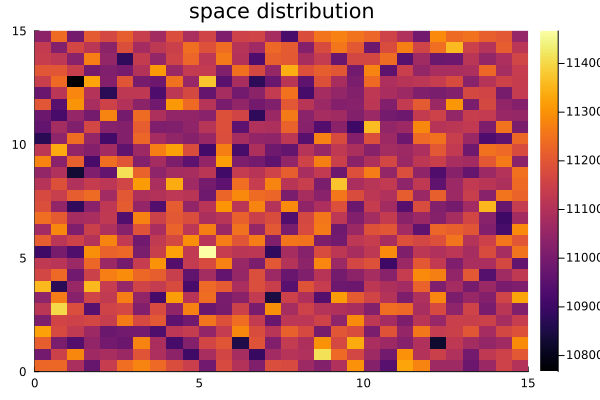

In [6]:
plot(histogram2d(par_dis[1:2D:end],par_dis[2:2D:end], title="space distribution", bins=50 ))

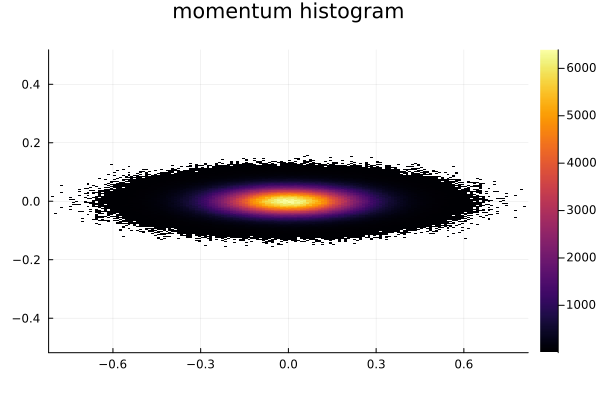

In [7]:
plot(histogram2d(par_dis[3:4:end],par_dis[4:4:end] )
,aspectratio=1
,title = "momentum histogram"
)

### Check Temperature

In [8]:
T = get_temperature_rel_D(par_dis,N,D)

0.012994119553211574

In [9]:
#include("aux_functions/aux_functions.jl")
#par_grid = (N, Box_x, J, 5)
#n = zeros(J)
#get_density_2D!(par_dis, n, par_grid)

get_density_2D_trans = Density2DTrans(N, J)
n = get_density_2D_trans(Val(order), Box_x, par_dis);


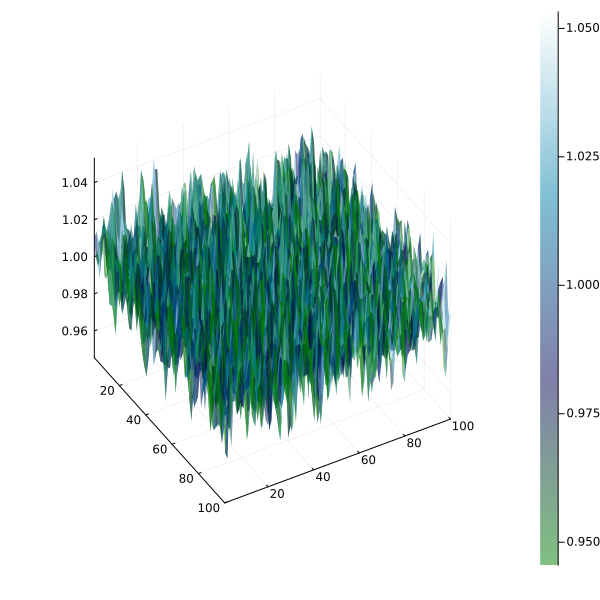

In [10]:
plot_matrix(n)

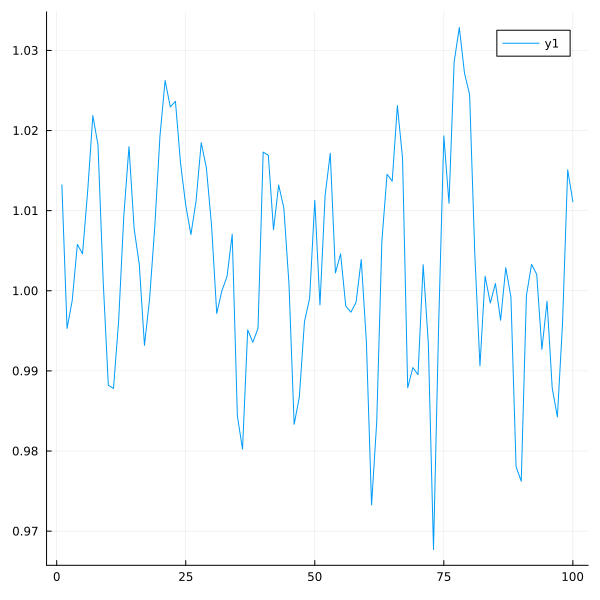

In [11]:
plot(n[:,2])

### Check Normalization

In [11]:
sum(n)/prod(J)

1.0

### Check Current

In [12]:
par_grid = (N, J, Box_x, 5)
#S = [0.0::Float64 for l in 1:2, i in 1:J[1], j in 1:J[2]]
#S_new  = [0.0::Float64 for i in 1:J[1], j in 1:J[2], l in 1:2]
#TS = zeros(Float64,(2,J...,nthreads()))

#par_current_threads_S = (par_grid, TS)

#get_current_threads_2D!(par_dis, S, par_current_threads_S)
#S_new = get_current_2D_trans(Val(order), N, J, Box_x, par_dis)


get_current_2D_trans = Current2DTrans(N, J)
S = get_current_2D_trans(Val(order), Box_x, par_dis)
@show sum(S[:,:,1])

sum(S[:, :, 1]) = -2.7755575615628914e-17


-2.7755575615628914e-17

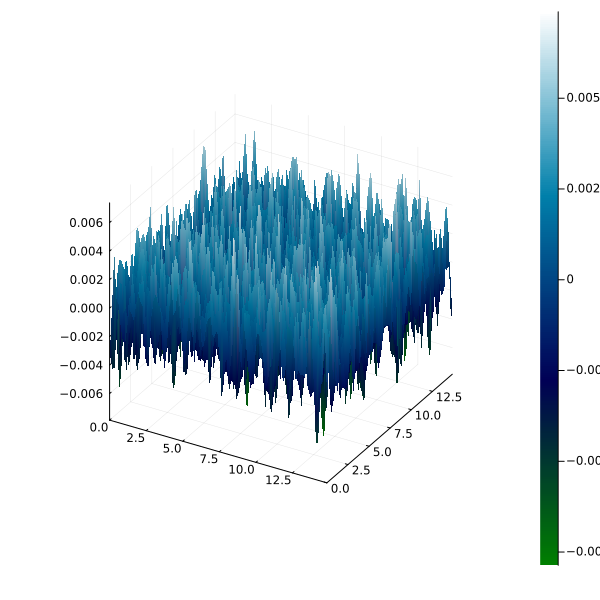

In [13]:
surface(y_p,x_p, S[:,:,1])

## Electric and Magnetic initial data

In [14]:
# We prescrive a constant magnetic field and the E is just a solution from Poisson's equations. 

B0 = 0.0 #initial magnetic field

B = [B0 for i in 1:J[1], j in 1:J[2]]

run_name = run_name * "_B0_$(convert(Int,trunc(B0)))"

"weibel_norel_Box_15.0x15.0_J_100x100_Ax_24_Th3_alp8tf_40_N7_M201_o5_B0_0"

In [15]:
E = Array{Float64,3}(undef,(2,J...))
#ρ = n.-1.0/prod(J)
ρ = n.-1.0
@show sum(ρ)
get_E!(E,ρ,Box_x);

sum(ρ) = 5.222489107836736e-13


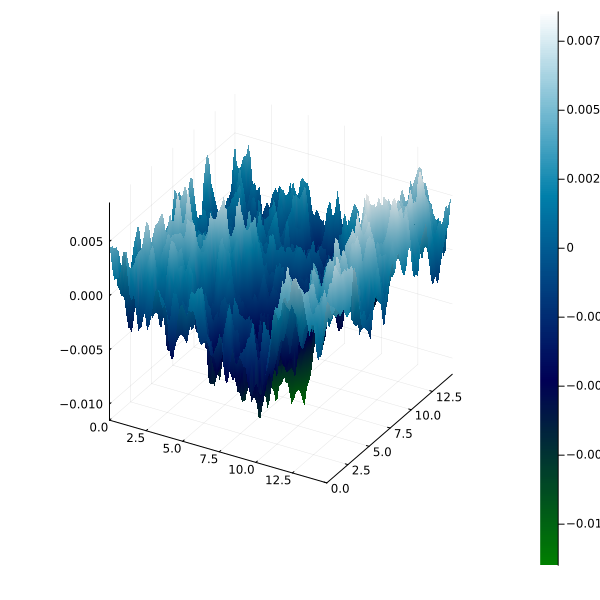

In [18]:
surface(y_p,x_p, E[2,:,:])

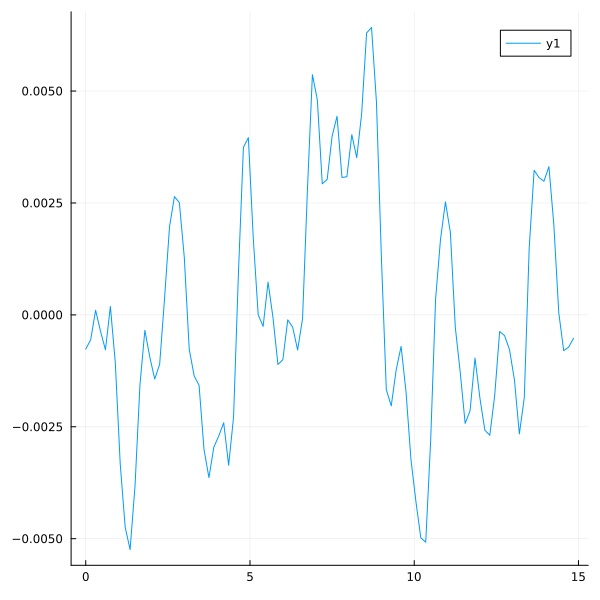

In [17]:
plot(x_p, E[1,:,5])

In [23]:
average_outputs = false # detailed output (for runs which are too long)
full_outputs = false
animation = false # to run animations
phase_space_show = false #show phase space diagrams
#phase_space_show = true
remote_server = false # if run in remote_server as a script avoid all plots 
save_plots = false # put true is you want so save your plots.
#full_outputs = true
average_outputs = true
#animation = true

true

We build the initial data:

In [19]:
u = Vector{Float64}(undef, 4N + 3*prod(J)); # contains r, v and E and B

du = Vector{Float64}(undef, 4N + 3*prod(J)); # contains r, v and E

u[1:4N] = par_dis 

Fu = view(u,4N+1:4N+3*prod(J))

F = reshape(Fu,3,J...)

#F = view(u[4N+1:end],3,J...)
F[1:2,:,:] = E
F[3,:,:] = B;

# the total electric energy is:

(norm(E)^2 + norm(B)^2)*prod(dx)
#u
#F[3,:,:]



0.003471425607443203

In [ ]:
#surface(y_p,x_p,F[1,:,:])

In [20]:
Energy_Ks, Energy_Es = get_energy_rel(u,(Box_x, N, J))

(2.872554369108947, 0.0017357128037216022)

In [ ]:
#surface(y_p,x_p,F[3,:,:])

In [14]:
u[4N+2*prod(J)+1:end]
#u[4N+1:end-prod(J)]

4096-element Vector{Float64}:
  0.0
  0.0013918691325724075
 -0.0012416294461422626
  0.0
  0.0013150550760043624
 -0.0012445029274218838
  0.0
  0.002468232494616575
 -0.0006185020474755143
  0.0
  ⋮
 -0.0012799871697970278
 -0.0020380733685092167
  0.0
 -0.0004950568828375242
 -0.0034511578144604538
  0.0
  0.001212409105904193
 -0.003500273663060388
  0.0

With the particle distribution we construct the initial data for the electric field. For that first we compute de density, using different types of particles (order).

### What follows are characterizations of the initial data properties.

In [22]:

Coordinate_test(u,Box_x,N)

#println("n_total = $(sum(n .- 1.0))")
#println("v_total = $(sum(u[N+1:2N]))")
#println("E_total = $(sum(E_i))")

#println("S_total = $(sum(S))")

test passed


## TIME Evolution: 

Now we make the time evolution:

1. we define parameters and vectors where to upload data to study the time evolution: Kinetic Energy, Electric field Energy, Total Electric field, total velocity (momentum), total density, total charge current.

2. we save a vector with the particle phase space, this can be a lot of memory!

In [21]:

if nthreads() > 1
#TS = zeros(Float64, (2,J...,nthreads()))
#p_RHS_D = (N, J, Box_x, order, n, S, du, get_density_2D!, get_current_threads_2D!, Interpolate_EBv_1, TS, Dx, Δx, σx, Dy, Δy, σy) ;
p_RHS_D_slim = (order, N, J, Box_x, order, n, S, du, get_density_2D!, get_current_slim, Interpolate_All_EBv_2_slim, Dx, Δx, σx, Dy, Δy, σy, maxwell, dissipation) ;
else
p_RHS_D = (N, J, Box_x, order, n, S, du, get_density_2D!, get_current_rel_2D!, Interpolate_EBv_1, Dx, Δx, σx, Dy, Δy, σy, maxwell, dissipation) ;
end


(5, 10000000, (100, 100), (0.0, 15.0, 0.0, 15.0), 5, [1.0101258237648791 1.0132204067403543 … 0.982712707432471 0.9892845371766082; 1.0014358813522906 0.9953001186555794 … 0.9789799287724519 0.9894627979733681; … ; 1.021712609811736 1.0151034044910394 … 0.9826662512239398 1.0001670292467668; 1.0184929654062633 1.011103443203286 … 0.9875101996921514 1.0019629302676571], [-0.0032113849598085237 0.00016297658918762914 … 0.002840388434600566 -0.0014882056673852283; -0.0038424624206608187 -0.0005845864337024048 … 0.002927878738096177 -0.0012800863211979117; … ; -0.005996898427538555 -0.0027687380465735677 … 0.0005458925054006699 -0.0039758804853012655; -0.0031067301399080966 9.535651115067554e-5 … -0.0002834047527089722 -0.0034696446800085443;;; 0.00014735378739930393 7.942342866788003e-5 … -0.0002252731548931793 0.0006243705322265494; -6.519009003118158e-6 0.00026904888481263937 … 9.927629851778675e-5 5.9981948139804896e-5; … ; 0.0004229197212421592 0.00031110608660309553 … 5.2039193715308

In [25]:
#include("aux_functions/aux_functions.jl")
t = 0.0
j = 1

run_pars = Dict("run_name" => run_name, "par_grid" => par_grid, "par_evolv" => par_evolv, "p_Ini" => (par_f_x, par_f_p))

if full_outputs
    run_name = run_name * "_full"
elseif average_outputs
    run_name = run_name * "_ave"
end

file_name = "Results/"* run_name * ".jld2"
#rm(file_name)




save(file_name, run_pars)

if false # solo para testear
file = jldopen(file_name, "r+")
close(file)
end

if full_outputs
    field_name = "u"
    tiempo = @sprintf("%05d", j)
    jldopen(file_name, "a+") do file
        file[field_name * "/u_$(tiempo)"] = u;
    end
end

if average_outputs
    load_averages_D(file_name, j, par_grid)#, pars_f)
end

if animation
    par = Array{Float64,2}(undef,M_g,length(u));
    par[1,:] = u[:]
end

In [18]:
@show file_name
@show full_outputs
@show average_outputs


file_name = "Results/weibel_I2Box_15.0x15.0_J_64x64_Ax_25_Th3_alp8tf_40_N7_M201_o5_B0_0_ave.jld2"
full_outputs = false
average_outputs = true


true

In [19]:
#include("aux_functions/aux_functions.jl")
for k in 2:M
  RK4_Step!(RHS_D_slim!,u,t,dt,p_RHS_D_slim)
  #global u = [make_periodic!(u[1:4N],Box_x); u[4N+1:end]]
  # make_periodic!(u,Box_x,N) # done inside the RHS_D function at every RK step
  #filter_constant!(u[2N+1:end])
  global t = t + dt
  if (k-1) % (M÷(M_g-1)) == 0
    local j = (k-1)÷(M÷(M_g-1))+1
    make_periodic!(u,Box_x,N) # just to save the correct data
    global Energy_Ks, Energy_Es = get_energy_rel(u,(Box_x, N, J))

    if average_outputs
      load_averages_D(file_name, j, par_grid)
    end

    if full_outputs
        local tiempo = @sprintf("%05d", j)
        jldopen(file_name, "a+") do file
            file[field_name * "/u_$(tiempo)"] = u
      end
    end

    println("j = $j , t = $t, k = $k, nthreads = $(nthreads()), Total_Energy = $(Energy_Ks + Energy_Es), E_Energy = $(Energy_Es)")

    if animation
      par[j,:] = u[:]
    end
  end
end

j = 2 , t = 0.02, k = 2, nthreads = 10, Total_Energy = 0.7850693488045568, E_Energy = 0.001098904092368927


j = 3 , t = 0.04, k = 3, nthreads = 10, Total_Energy = 0.7850693031486572, E_Energy = 0.00109791800266004


j = 4 , t = 0.06, k = 4, nthreads = 10, Total_Energy = 0.7850692392797937, E_Energy = 0.001096224483484644


j = 5 , t = 0.08, k = 5, nthreads = 10, Total_Energy = 0.7850691570170567, E_Energy = 0.0010938253587778563


j = 6 , t = 0.1, k = 6, nthreads = 10, Total_Energy = 0.785069056104745, E_Energy = 0.0010907232522137313


j = 7 , t = 0.12000000000000001, k = 7, nthreads = 10, Total_Energy = 0.7850689362188016, E_Energy = 0.0010869215986671432


j = 8 , t = 0.14, k = 8, nthreads = 10, Total_Energy = 0.7850687969779784, E_Energy = 0.0010824246583536945


j = 9 , t = 0.16, k = 9, nthreads = 10, Total_Energy = 0.7850686379549091, E_Energy = 0.0010772375331803878


j = 10 , t = 0.18, k = 10, nthreads = 10, Total_Energy = 0.7850684586877166, E_Energy = 0.001071366184761548


j = 11 , t = 0.19999999999999998, k = 11, nthreads = 10, Total_Energy = 0.7850682586953536, E_Energy = 0.001064817453491888


j = 12 , t = 0.21999999999999997, k = 12, nthreads = 10, Total_Energy = 0.7850680374916001, E_Energy = 0.0010575990780226042


j = 13 , t = 0.23999999999999996, k = 13, nthreads = 10, Total_Energy = 0.7850677946004095, E_Energy = 0.0010497197144582408


j = 14 , t = 0.25999999999999995, k = 14, nthreads = 10, Total_Energy = 0.7850675295710904, E_Energy = 0.0010411889545824725


j = 15 , t = 0.27999999999999997, k = 15, nthreads = 10, Total_Energy = 0.7850672419930587, E_Energy = 0.0010320173424289195


j = 16 , t = 0.3, k = 16, nthreads = 10, Total_Energy = 0.7850669315099772, E_Energy = 0.0010222163885381835


j = 17 , t = 0.32, k = 17, nthreads = 10, Total_Energy = 0.7850665978337605, E_Energy = 0.0010117985812833571


j = 18 , t = 0.34, k = 18, nthreads = 10, Total_Energy = 0.785066240755985, E_Energy = 0.0010007773947017398


j = 19 , t = 0.36000000000000004, k = 19, nthreads = 10, Total_Energy = 0.7850658601586532, E_Energy = 0.0009891672923383014


j = 20 , t = 0.38000000000000006, k = 20, nthreads = 10, Total_Energy = 0.7850654560232552, E_Energy = 0.00097698372668421


j = 21 , t = 0.4000000000000001, k = 21, nthreads = 10, Total_Energy = 0.7850650284380498, E_Energy = 0.000964243133879366


j = 22 , t = 0.4200000000000001, k = 22, nthreads = 10, Total_Energy = 0.7850645776021912, E_Energy = 0.0009509629234384804


j = 23 , t = 0.4400000000000001, k = 23, nthreads = 10, Total_Energy = 0.7850641038298795, E_Energy = 0.0009371614628532665


j = 24 , t = 0.46000000000000013, k = 24, nthreads = 10, Total_Energy = 0.7850636075507049, E_Energy = 0.0009228580570171235


j = 25 , t = 0.48000000000000015, k = 25, nthreads = 10, Total_Energy = 0.7850630893083302, E_Energy = 0.0009080729225106733


j = 26 , t = 0.5000000000000001, k = 26, nthreads = 10, Total_Energy = 0.7850625497578476, E_Energy = 0.0008928271568744033


j = 27 , t = 0.5200000000000001, k = 27, nthreads = 10, Total_Energy = 0.7850619896610287, E_Energy = 0.0008771427030768656


j = 28 , t = 0.5400000000000001, k = 28, nthreads = 10, Total_Energy = 0.7850614098789096, E_Energy = 0.0008610423094616271


j = 29 , t = 0.5600000000000002, k = 29, nthreads = 10, Total_Energy = 0.7850608113641946, E_Energy = 0.0008445494855223508


j = 30 , t = 0.5800000000000002, k = 30, nthreads = 10, Total_Energy = 0.7850601951521464, E_Energy = 0.0008276884539120913


j = 31 , t = 0.6000000000000002, k = 31, nthreads = 10, Total_Energy = 0.7850595623496913, E_Energy = 0.0008104840991389284


j = 32 , t = 0.6200000000000002, k = 32, nthreads = 10, Total_Energy = 0.7850589141241533, E_Energy = 0.0007929619134351537


In [ ]:
j = 11

Plots.scatter(par[j,1:2D:4N], par[j,2:2D:4N], ts=0.2
, thickness_scaling = 0.3
, markersize = 0.3
, title = "space", legend =:false)

#png("weibel_space_t=10")

In [ ]:
#include("aux_functions/aux_functions.jl")


#make_periodic!(par[M_g,:],Box_x,N)
Coordinate_test(par[M_g,:],Box_x,N)

In [ ]:
j = 11

histogram2d(par[j,1:2D:4N], par[j,2:2D:4N], ts=0.2
, thickness_scaling = 0.3
, markersize = 0.3
, title = "space", legend =:false)

In [ ]:
j = 11
Plots.scatter(par[j,3:2D:4N], par[j,4:2D:4N], ts=0.2
, thickness_scaling = 0.3
, markersize = 0.3
, title = "momentum", legend =:false)

#png("weibel_momentum_t=10")

In [ ]:
j = M_g
Fuj = view(par[j,:],4N+1:4N+3*prod(J))

Fj = reshape(Fuj,3,J...)

#F = view(u[4N+1:end],3,J...)
Ej = Fj[1:2,:,:]
Bj = Fj[3,:,:];

#surface(y_p,x_p,Ej[2,:,:])
#surface(y_p,x_p,Bj[:,:])

#norm(Bj)

In [ ]:
plot(Ej[1,:,50])
plot!(Bj[:,50])

In [ ]:
l = 1
P = 5
plot()
for j in 1:M_g
    Fuj = view(par[j,:],4N+1:4N+3*prod(J))
    Fj = reshape(Fuj,3,J...)
    Ej = Fj[1:2,:,:]
    Bj = Fj[3,:,:];
    plot!(Ej[l,:,P])
    plot!(Bj[:,P])
end
plot!(legend=false)

In [ ]:
norm(par[1,4N+1:4N+3*prod(J)] - par[11,4N+1:4N+3*prod(J)])/norm(par[1,4N+1:4N+3*prod(J)])

### Momentum rotation

### Constraint cheking

In [ ]:
j = M_g
par_grid = (N, Box_x, J, 5)

#nf = get_density_2D_trans(Val(order), Box_x, par[j,1:4N])

#Ef = Array{Float64,3}(undef,(2,J...))
#ρf = nf.-1.0/prod(J)
#ρf = nf .-1.0
#@show sum(ρf)
#get_E!(Ef,ρf,Box_x);

Fuj = view(par[j,:],4N+1:4N+3*prod(J))
Fj = reshape(Fuj,3,J...)
#F = view(u[4N+1:end],3,J...)
Ej = Fj[1:2,:,:]
@show(norm(Ej))

#### They do not coincide because there are waves starting. But the weak form of the constraints is satisfied, as we shall see below.

In [ ]:
nf = get_density_2D_trans(Val(order), Box_x, par[M_g,1:4N])
ρf = nf .-1.0;

In [ ]:
#include("aux_functions/aux_functions_E-B.jl")
x0=[Box_x[1] + (Box_x[2]-Box_x[1])*rand(), Box_x[3] + (Box_x[4]-Box_x[3])*rand()]
@show x0
pars = (x0, 0.2, 6)
constraint_test(Ej, ρf, J, Box_x, ϕ_test, ∇ϕ_test, pars)

In [ ]:
Err = 0.0
Max = 0.0
M = 100
for i in 1:M
    x0=[Box_x[1] + (Box_x[2]-Box_x[1])*rand(), Box_x[3] + (Box_x[4]-Box_x[3])*rand()]
    pars = (x0, 0.2, 6)
    div, rho, err = constraint_test(Ej, ρf, J, Box_x, ϕ_test, ∇ϕ_test, pars)
    Err = Err + abs(err)
    if err > Max
        @show Max = err
        @show x0
    end
    
end
@show Err/M
@show Max;